## System rozmyty (bez danych bukmacherskich)

### Import bibliotek

In [290]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from simpful import *

### Lista kolumn do wykorzystania w analizie

In [291]:
# Kolumny uzyskane na podstawie analizy korelacji oraz ważności cech (XGBoostClassifier)
final_columns = [
    'diff_team_penalty_area_touches_avg_last_15_matches',
    'diff_team_momentum_sum_avg_last_15_matches',
    'diff_team_score_xG_sum_last_15_matches',
    'diff_team_momentum_sum_sum_last_7_matches',
    'diff_team_attacking_third_touches_avg_last_13_matches',
    'diff_team_momentum_sum_sum_last_9_matches',
    'diff_team_momentum_sum_avg_last_11_matches',
    'diff_team_penalty_area_touches_sum_last_7_matches',
    'diff_team_carries_into_the_penalty_area_sum_last_15_matches',
    'diff_team_penalty_area_touches_avg_last_13_matches',
    'diff_team_points_sum_last_15_matches',
    'diff_team_points_sum_last_13_matches',
    'diff_team_momentum_count_avg_last_7_matches',
    'diff_team_shots_on_target_avg_last_13_matches',
    'diff_team_carries_into_the_penalty_area_sum_last_13_matches',
    'diff_team_attacking_third_touches_sum_last_11_matches',
    'diff_team_momentum_sum_avg_last_13_matches',
    'diff_team_score_xG_avg_last_9_matches',
    'diff_team_score_xG_sum_last_13_matches',
    'diff_team_progressive_passes_sum_last_11_matches',
    'diff_team_score_xG_avg_last_7_matches',
    'diff_team_attacking_third_touches_sum_last_15_matches',
    'diff_team_momentum_count_sum_last_11_matches'
]  # 23 kolumny

### Wczytanie i przygotowanie danych

In [292]:
dane = {
    'premier_league': {
        'train': pd.read_pickle('data/premier_league/train_data_statistics.pkl'),
        'test': pd.read_pickle('data/premier_league/test_data_statistics.pkl')
    },
    'laliga': {
        'train': pd.read_pickle('data/laliga/train_data_statistics.pkl'),
        'test': pd.read_pickle('data/laliga/test_data_statistics.pkl')
    },
    'serie_a': {
        'train': pd.read_pickle('data/serie_a/train_data_statistics.pkl'),
        'test': pd.read_pickle('data/serie_a/test_data_statistics.pkl')
    }
}

### Przygotowanie zmiennych lingwistycznych wejściowych

Ze względu na dużą liczbę zmiennych lingwistycznych, w celu uproszczenia zmienne te są tworzone w sposób zautomatyzowany. 

Dla każdej zmiennej wejściowej dla modelu:
* generowane są trzy termy: `low`, `medium`, `high`;
* obliczane są kwantyle (`0.25`, `0.5`, `0.75`) oraz wartości minimalne i maksymalne, które służą jako punkty odniesienia dla termów oraz określają zakres uniwersum zmiennej lingwistycznej;
* zmienna lingwistyczna jest tworzona na podstawie termów oraz zadanego uniwersum.

In [293]:
# Definicja zmiennej lingwistycznej na podstawie kwantyli
def create_linguistic_variable(data: pd.Series, percentiles: tuple[float] = (0.25, 0.5, 0.75),
                               concept: str = "Concept") -> LinguisticVariable:
    """
    Funkcja tworząca zmienną lingwistyczną na podstawie percentyli.
    
    :param data: Dane (pd.Series)
    :param percentiles: Percentyle (tuple[float])
    :param concept: Nazwa zmiennej lingwistycznej (str)
    """
    # Opis statystyczny danych
    description = data.describe(percentiles=percentiles)

    # Uniwersum zmiennej lingwistycznej
    universe_of_discourse = [description["min"], description["max"]]

    # Nazwy kwantyli
    percentiles_names = [f"{int(q * 100)}%" for q in percentiles]

    # Zbiory rozmyte - niski, średni, wysoki
    LOW_TERM = FuzzySet(points=[[description["min"], 1], [description[percentiles_names[0]], 1],
                                [description[percentiles_names[1]], 0]], term="low")
    MEDIUM_TERM = FuzzySet(points=[[description[percentiles_names[0]], 0], [description[percentiles_names[1]], 1],
                                   [description[percentiles_names[2]], 0]], term="medium")
    HIGH_TERM = FuzzySet(points=[[description[percentiles_names[1]], 0], [description[percentiles_names[2]], 1],
                                 [description["max"], 1]], term="high")

    # Zmienna lingwistyczna
    return LinguisticVariable([LOW_TERM, MEDIUM_TERM, HIGH_TERM], concept=concept,
                              universe_of_discourse=universe_of_discourse)

Przykład wygenerowanej zmiennej lingwistycznej dla jednej z kolumn:

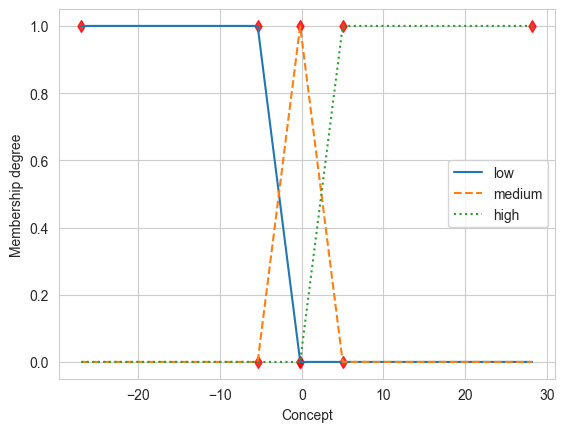

In [294]:
create_linguistic_variable(dane["premier_league"]["train"]["diff_team_score_xG_sum_last_15_matches"]).plot()

### Klasyfikator rozmyty

In [295]:
class FuzzyClassifier(BaseEstimator):
    """
    Klasa klasyfikatora rozmytego.
    """

    def __init__(self):
        # Inicjalizacja modelu
        self.model = FuzzySystem()

        # Słownik zmiennych lingwistycznych
        self.linguistic_variables = {}

        # Zmienna lingwistyczna wyjściowa
        self.output_linguistic_variable = None

        # Inicjalizacja wyjściowej zmiennej lingwistycznej
        self._init_output_linguistic_variable()

    def init_linguistic_variables(self, X: pd.DataFrame, percentiles: tuple[float] = (0.25, 0.5, 0.75)):
        """
        Metoda inicjalizująca zmienne lingwistyczne na podstawie dostarczonych danych.
        
        :param X: Dane (pd.DataFrame)
        :param percentiles: Percentyle (tuple[float])
        """
        for column in X.columns:
            self.linguistic_variables[column] = create_linguistic_variable(X[column], percentiles=percentiles,
                                                                           concept=column)
            self.model.add_linguistic_variable(column, self.linguistic_variables[column])

    def add_rules(self, rules: list[str]):
        """
        Metoda dodająca reguły do modelu.
        
        :param rules: Lista reguł (list[str])
        """
        self.model.add_rules(rules)

    def predict(self, X: pd.DataFrame, thresholds: tuple[float] = (0.33, 0.66), y_true: np.array = None):
        """
        Metoda dokonująca predykcji na podstawie dostarczonych danych.
        
        :param X: Dane (pd.DataFrame)
        :param thresholds: Progi określające przydział do klas (tuple[float])
        :param y_true: Etykiety klas rzeczywistych (np.array)
        
        :return: Predykcje (np.array)
        """
        predictions = []
        for _, row in X.iterrows():
            for column, value in row.items():
                self.model.set_variable(column, value)
            result = self.model.inference()["Match_Result"]
            print(result, y_true[_]) if y_true is not None else None

            if result < thresholds[0]:
                predictions.append(-1)
            elif result < thresholds[1]:
                predictions.append(0)
            else:
                predictions.append(1)

        return np.array(predictions)

    def calculate_metrics(self, y_true: np.array, y_pred: np.array):
        """
        Metoda obliczająca metryki klasyfikacji.
        
        :param y_true: Etykiety klas rzeczywistych (np.array)
        :param y_pred: Etykiety klas predykowanych (np.array)
        
        :return: Słownik z metrykami klasyfikacji (accuracy, precision, recall, f1)
        """
        return {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, average="macro"),
            "recall": recall_score(y_true, y_pred, average="macro"),
            "f1": f1_score(y_true, y_pred, average="macro")
        }

    def plot_classification_report(self, y_true: np.array, y_pred: np.array):
        """
        Metoda wizualizująca raport klasyfikacji.
        
        :param y_true: Etykiety klas rzeczywistych (np.array)
        :param y_pred: Etykiety klas predykowanych (np.array
        """
        # Raport klasyfikacji
        report = classification_report(y_true, y_pred, output_dict=True)

        # Wizualizacja raportu w formie heatmapy
        sns.heatmap(pd.DataFrame(report).T, annot=True, cmap="coolwarm")

    def _init_output_linguistic_variable(self):
        """
        Metoda inicjalizująca wyjściową zmienną lingwistyczną.
        """
        LOSS = FuzzySet(points=[[0, 1], [0.25, 1], [0.5, 0]], term="loss")
        DRAW = FuzzySet(points=[[0.25, 0], [0.5, 1], [0.75, 0]], term="draw")
        WIN = FuzzySet(points=[[0.5, 0], [0.75, 1], [1, 1]], term="win")
        OUTPUT_MATCH_RESULT = LinguisticVariable([LOSS, DRAW, WIN], concept="Match_Result",
                                                 universe_of_discourse=[0, 1])

        self.output_linguistic_variable = OUTPUT_MATCH_RESULT
        self.model.add_linguistic_variable("Match_Result", OUTPUT_MATCH_RESULT)

### Inicjalizacja klasyfikatora rozmytego

In [296]:
fuzzy_classifier = FuzzyClassifier()
fuzzy_classifier.init_linguistic_variables(dane["premier_league"]["train"][final_columns])

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.12.0 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 https://github.com/aresio/simpful



### Wyjściowa zmienna lingwistyczna

* trzy termy: `loss`, `draw`, `win`;
* uniwersum: `[0, 1]`.

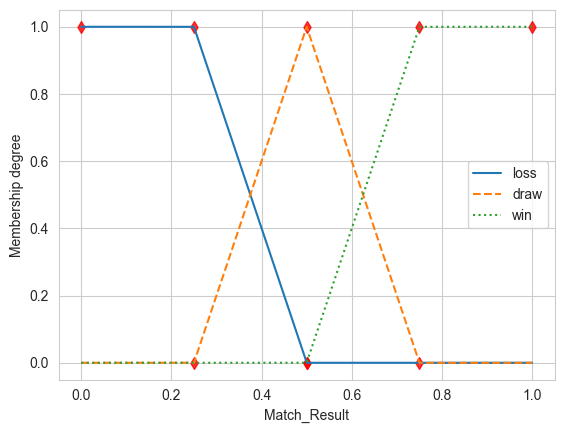

In [297]:
fuzzy_classifier.output_linguistic_variable.plot()

### Reguły eksperckie

Reguły eksperckie zostały zdefiniowane na podstawie analizy danych oraz intuicji.

In [298]:
rules = [
    # Win
    "IF (diff_team_momentum_sum_avg_last_15_matches IS high) THEN Match_Result IS win",
    "IF (diff_team_score_xG_sum_last_15_matches IS high) OR (diff_team_score_xG_sum_last_13_matches IS high) THEN Match_Result IS win",
    "IF (diff_team_penalty_area_touches_avg_last_15_matches IS high) AND (diff_team_attacking_third_touches_avg_last_13_matches IS high) THEN Match_Result IS win",
    "IF (diff_team_points_sum_last_15_matches IS high) OR (diff_team_points_sum_last_13_matches IS high) THEN Match_Result IS win",

    # Draw
    "IF (diff_team_momentum_sum_avg_last_15_matches IS medium) AND (diff_team_penalty_area_touches_avg_last_13_matches IS low) THEN Match_Result IS draw",
    "IF (diff_team_points_sum_last_15_matches IS medium) AND (diff_team_shots_on_target_avg_last_13_matches IS medium) THEN Match_Result IS draw",
    "IF (diff_team_progressive_passes_sum_last_11_matches IS medium) AND (diff_team_score_xG_avg_last_7_matches IS medium) THEN Match_Result IS draw",

    # Loss
    "IF (diff_team_score_xG_sum_last_15_matches IS low) AND (diff_team_momentum_sum_avg_last_15_matches IS low) THEN Match_Result IS loss",
    "IF (diff_team_carries_into_the_penalty_area_sum_last_15_matches IS low) AND (diff_team_penalty_area_touches_avg_last_15_matches IS low) THEN Match_Result IS loss",
    "IF (diff_team_progressive_passes_sum_last_11_matches IS low) AND (diff_team_score_xG_sum_last_13_matches IS low) THEN Match_Result IS loss",
]

fuzzy_classifier.add_rules(rules)

### Wyniki klasyfikacji modelu rozmytego na danych Premier League

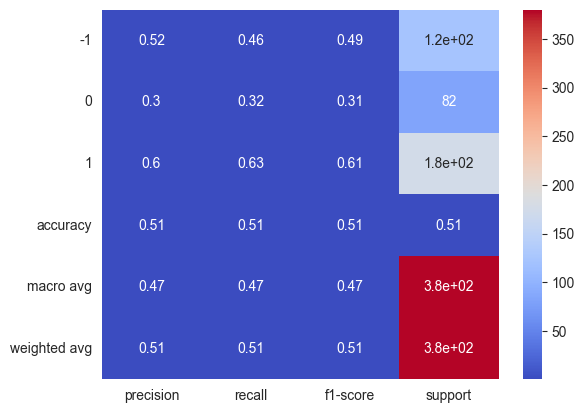

In [299]:
fuzzy_classifier.plot_classification_report(dane["premier_league"]["test"]["match_outcome_encoded"],
                                            fuzzy_classifier.predict(dane["premier_league"]["test"][final_columns]))

### Wyniki klasyfikacji modelu rozmytego na danych La Liga

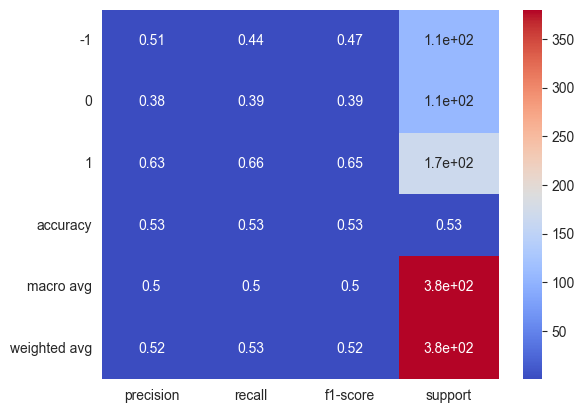

In [300]:
fuzzy_classifier.plot_classification_report(dane["laliga"]["test"]["match_outcome_encoded"],
                                            fuzzy_classifier.predict(dane["laliga"]["test"][final_columns]))